完整城市数: 104
PCA降维后维度: 8 (保留90%方差)
best clusters = 2


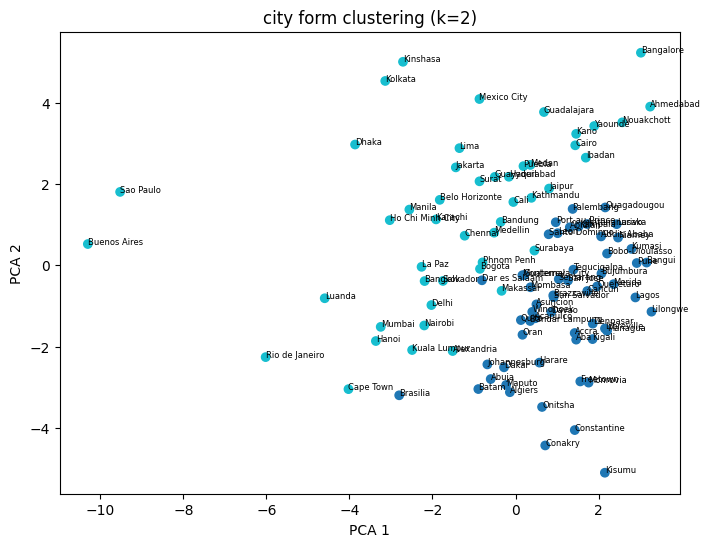

结果已保存为 city_clustering_results.csv


In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ========== 1. 读取数据 ==========
cities = pd.read_csv("CitiesDB_new.csv")
zib = pd.read_csv("zib_fitting_results.csv")
height = pd.read_csv("height_fitting_results(log_ols).csv")

# 统一城市和年份字段命名
zib = zib.rename(columns={'city': 'Name'})
height = height.rename(columns={'city': 'Name'})

# ========== 2. 合并ZIB和HEIGHT结果 ==========
merged = zib.merge(height, on=["Name", "year"], how="inner")

# merged 列示例：
# Name | year | alpha_zi | beta_zi | alpha_bin | beta_bin | alpha | beta | gamma

# ========== 3. 拆分2016和2023 ==========
wide = merged.pivot(index="Name", columns="year")
# 列是多层索引 (param, year)，我们需要整理
wide.columns = [f"{param}_{year}" for param, year in wide.columns]
wide = wide.reset_index()

# ========== 4. 合并城市元信息 ==========
df = cities.merge(wide, on="Name", how="inner")

# 检查是否每个城市都有2016和2023数据
print(f"完整城市数: {len(df)}")

# ========== 5. 构造特征矩阵 ==========
feature_cols = [
    "alpha_zi_2016", "beta_zi_2016", "alpha_bin_2016", "beta_bin_2016",
    "alpha_2016", "beta_2016", "gamma_2016",
    "alpha_zi_2023", "beta_zi_2023", "alpha_bin_2023", "beta_bin_2023",
    "alpha_2023", "beta_2023", "gamma_2023"
]

# 确保列存在
X = df[feature_cols].copy()

# ========== 6. 可选：加入变化量特征 ==========
for c in ["alpha_zi", "beta_zi", "alpha_bin", "beta_bin", "alpha", "beta", "gamma"]:
    df[f"{c}_change"] = df[f"{c}_2023"] - df[f"{c}_2016"]
    feature_cols.append(f"{c}_change")

# ========== 7. 标准化 ==========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

# ========== 8. PCA降维 ==========
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA降维后维度: {X_pca.shape[1]} (保留90%方差)")

# ========== 9. 寻找最优簇数 ==========
scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    scores.append((k, score))

best_k = max(scores, key=lambda x: x[1])[0]
print("best clusters =", best_k)

# ========== 10. 最终聚类 ==========
kmeans = KMeans(n_clusters=best_k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_pca)

# ========== 11. 可视化 ==========
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cluster"], cmap="tab10")
for i, name in enumerate(df["Name"]):
    plt.text(X_pca[i,0], X_pca[i,1], name, fontsize=6)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title(f"city form clustering (k={best_k})")
plt.show()

# ========== 12. 保存结果 ==========
df.to_csv("city_clustering_results.csv", index=False)
print("结果已保存为 city_clustering_results.csv")

best k = 2


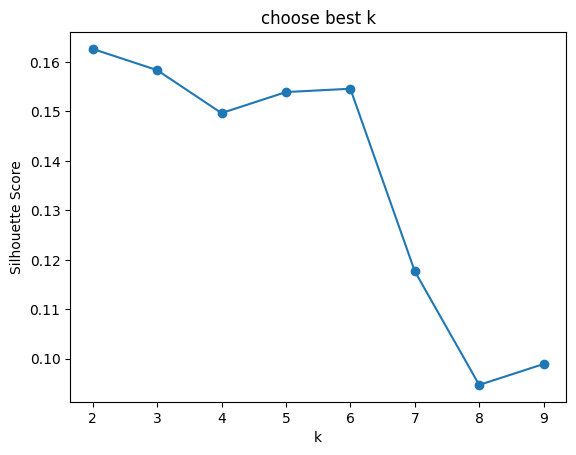

         alpha_zi_2016  beta_zi_2016  alpha_bin_2016  beta_bin_2016  \
cluster                                                               
0            -0.202233      0.235485       -0.397507      -0.067745   
1            -0.789515      0.379692        0.006499      -0.109181   

         alpha_2016  beta_2016  gamma_2016  alpha_zi_2023  beta_zi_2023  \
cluster                                                                   
0          1.803718  -0.039715    0.001171      -0.252148      0.236054   
1          2.208798  -0.116395    0.006855      -0.797329      0.381093   

         alpha_bin_2023  ...  alpha_2023  beta_2023  gamma_2023  \
cluster                  ...                                      
0             -0.333635  ...    1.799112  -0.044084    0.001399   
1              0.015333  ...    2.171314  -0.121259    0.007354   

         alpha_zi_change  beta_zi_change  alpha_bin_change  beta_bin_change  \
cluster                                                           

In [8]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# ========== 1. 读取数据 ==========
cities = pd.read_csv("CitiesDB_new.csv")
zib = pd.read_csv("zib_fitting_results.csv")
height = pd.read_csv("height_fitting_results(log_ols).csv")

# 统一命名
zib = zib.rename(columns={'city': 'Name'})
height = height.rename(columns={'city': 'Name'})

# 合并参数结果
merged = zib.merge(height, on=["Name", "year"], how="inner")

# pivot成宽表
wide = merged.pivot(index="Name", columns="year")
wide.columns = [f"{param}_{year}" for param, year in wide.columns]
wide = wide.reset_index()

# 合并城市元信息
df = cities.merge(wide, on="Name", how="inner")

# 构造特征
feature_cols = [
    "alpha_zi_2016", "beta_zi_2016", "alpha_bin_2016", "beta_bin_2016",
    "alpha_2016", "beta_2016", "gamma_2016",
    "alpha_zi_2023", "beta_zi_2023", "alpha_bin_2023", "beta_bin_2023",
    "alpha_2023", "beta_2023", "gamma_2023"
]

# 增加变化量特征
for c in ["alpha_zi", "beta_zi", "alpha_bin", "beta_bin", "alpha", "beta", "gamma"]:
    df[f"{c}_change"] = df[f"{c}_2023"] - df[f"{c}_2016"]
    feature_cols.append(f"{c}_change")

# ========== 2. 标准化 ==========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

# ========== 3. 确定最优簇数 ==========
scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append((k, score))

best_k = max(scores, key=lambda x: x[1])[0]
print("best k =", best_k)

# 可视化轮廓分数变化
plt.plot([k for k, _ in scores], [s for _, s in scores], marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("choose best k")
plt.show()

# ========== 4. 最终聚类 ==========
kmeans = KMeans(n_clusters=best_k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# ========== 5. 查看聚类结果 ==========
cluster_summary = df.groupby("cluster")[feature_cols].mean()
print(cluster_summary)

# ========== 6. 保存结果 ==========
df.to_csv("city_clustering_results_noPCA.csv", index=False)
print("已保存 city_clustering_results_noPCA.csv")

/tmp/ipykernel_8565/921382813.py:60: UserWarning: Glyph 22478 (\N{CJK UNIFIED IDEOGRAPH-57CE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8565/921382813.py:60: UserWarning: Glyph 24066 (\N{CJK UNIFIED IDEOGRAPH-5E02}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8565/921382813.py:60: UserWarning: Glyph 24418 (\N{CJK UNIFIED IDEOGRAPH-5F62}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8565/921382813.py:60: UserWarning: Glyph 24577 (\N{CJK UNIFIED IDEOGRAPH-6001}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8565/921382813.py:60: UserWarning: Glyph 32858 (\N{CJK UNIFIED IDEOGRAPH-805A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8565/921382813.py:60: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_8565/921382813.py:60: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missi

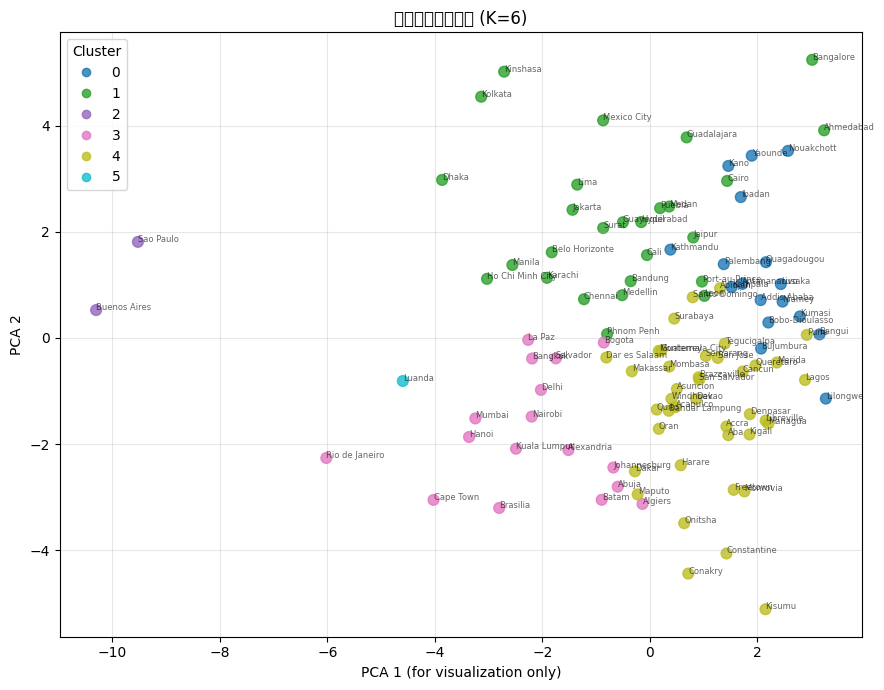


=== 每个簇的平均参数 ===
         alpha_zi_2016  beta_zi_2016  alpha_bin_2016  beta_bin_2016  \
cluster                                                               
0               -1.220         0.397          -0.536         -0.109   
1               -1.028         0.431           0.099         -0.129   
2               -1.060         0.342           0.144         -0.090   
3                0.246         0.214          -0.265         -0.043   
4               -0.039         0.203          -0.299         -0.064   
5               -0.045         0.265          -0.145         -0.145   

         alpha_2016  beta_2016  gamma_2016  alpha_zi_2023  beta_zi_2023  \
cluster                                                                   
0             1.693     -0.034       0.001         -1.393         0.419   
1             2.140     -0.098       0.004         -1.021         0.430   
2             2.699     -0.405       0.047         -1.046         0.337   
3             2.365     -0.125       0

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ========= 1. 读取数据 =========
cities = pd.read_csv("CitiesDB_new.csv")
zib = pd.read_csv("zib_fitting_results.csv")
height = pd.read_csv("height_fitting_results(log_ols).csv")

zib = zib.rename(columns={'city': 'Name'})
height = height.rename(columns={'city': 'Name'})

merged = zib.merge(height, on=["Name", "year"], how="inner")
wide = merged.pivot(index="Name", columns="year")
wide.columns = [f"{param}_{year}" for param, year in wide.columns]
wide = wide.reset_index()

df = cities.merge(wide, on="Name", how="inner")

# ========= 2. 构造特征 =========
feature_cols = [
    "alpha_zi_2016", "beta_zi_2016", "alpha_bin_2016", "beta_bin_2016",
    "alpha_2016", "beta_2016", "gamma_2016",
    "alpha_zi_2023", "beta_zi_2023", "alpha_bin_2023", "beta_bin_2023",
    "alpha_2023", "beta_2023", "gamma_2023"
]

# 可选：加入变化量特征
for c in ["alpha_zi", "beta_zi", "alpha_bin", "beta_bin", "alpha", "beta", "gamma"]:
    df[f"{c}_change"] = df[f"{c}_2023"] - df[f"{c}_2016"]
    feature_cols.append(f"{c}_change")

# ========= 3. 标准化 =========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[feature_cols])

# ========= 4. KMeans 聚类 (固定 k=6) =========
k = 6
kmeans = KMeans(n_clusters=k, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# ========= 5. 可视化 (PCA仅用于2D展示) =========
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled)

plt.figure(figsize=(9,7))
scatter = plt.scatter(X_vis[:,0], X_vis[:,1], c=df["cluster"], cmap="tab10", s=60, alpha=0.8)
plt.xlabel("PCA 1 (for visualization only)")
plt.ylabel("PCA 2")
plt.title(f"城市形态聚类结果 (K={k})")
plt.grid(alpha=0.3)

# 可选：添加城市名称标签（防止太密可选取一部分）
for i, name in enumerate(df["Name"]):
    plt.text(X_vis[i,0], X_vis[i,1], name, fontsize=6, alpha=0.6)

plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

# ========= 6. 输出聚类均值表 =========
cluster_summary = df.groupby("cluster")[feature_cols].mean().round(3)
print("\n=== 每个簇的平均参数 ===")
print(cluster_summary)

# ========= 7. 保存结果 =========
df.to_csv("city_clustering_k6.csv", index=False)
print("\n已保存结果至 city_clustering_k6.csv")
